## Neural Style

In [1]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg16, vgg19
from keras import backend as K
import numpy as np
import time
import glob
import imageio
from scipy.optimize import fmin_l_bfgs_b
from itertools import combinations

from scipy.misc import imread, imresize, imsave, fromimage, toimage

try:
    from io import BytesIO
except ImportError:
    from StringIO import StringIO as BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

Using TensorFlow backend.


In [2]:
base_image_path = 'style_transfer/Okerk2.jpg'
style1_image_path = 'style_transfer/water-lilies-1919-2.jpg'
style2_image_path = 'style_transfer/VanGogh-starry_night_ballance1.jpg'

In [3]:
def showarray(a, fmt='jpeg'):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def preprocess_image(image_path, target_size=None):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(x, w, h):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, w, h))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((w, h, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [4]:
w, h = 740, 468
style_image = K.variable(preprocess_image(style1_image_path, target_size=(h, w)))
result_image = K.placeholder(style_image.shape)
input_tensor = K.concatenate([style_image,
                              result_image], axis=0)
input_tensor.shape

TensorShape([Dimension(2), Dimension(468), Dimension(740), Dimension(3)])

In [5]:
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


In [6]:
class Evaluator(object):
    def __init__(self, loss_total, result_image, **other):
        grads = K.gradients(loss_total, result_image)
        outputs = [loss_total] + list(other.values()) + grads
        self.iterate = K.function([result_image], outputs)
        self.other = list(other.keys())
        self.other_values = {}
        self.shape = result_image.shape

        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        outs = self.iterate([x.reshape(self.shape)])
        self.loss_value = outs[0]
        self.grad_values = outs[-1].flatten().astype('float64')
        self.other_values = dict(zip(self.other, outs[1:-1]))
        return self.loss_value

    def grads(self, x):
        return np.copy(self.grad_values)

In [7]:
def gram_matrix(x):
    if K.image_data_format() != 'channels_first':
        x = K.permute_dimensions(x, (2, 0, 1))
    features = K.batch_flatten(x)
    return K.dot(features - 1, K.transpose(features - 1)) - 1

def style_loss(layer_1, layer_2):
    gr1 = gram_matrix(layer_1)
    gr2 = gram_matrix(layer_2)
    return K.sum(K.square(gr1 - gr2)) / (np.prod(layer_2.shape).value ** 2)

In [8]:
feature_outputs = [layer.output for layer in model.layers if '_conv' in layer.name]

loss_style = K.variable(0.)
for idx, layer_features in enumerate(feature_outputs):
    loss_style += style_loss(layer_features[0, :, :, :], layer_features[1, :, :, :])

style_evaluator = Evaluator(loss_style, result_image)

In [9]:
def run(evaluator, image, num_iter=25):
    for i in range(num_iter):
        start_time = time.time()

        image, min_val, info = fmin_l_bfgs_b(evaluator.loss, image.flatten(), fprime=evaluator.grads, maxfun=20)

        end_time = time.time()
        clear_output()
        showarray(deprocess_image(image.copy(), h, w))

        print("Iteration %d completed in %ds" % (i + 1, end_time - start_time))
        print("Current loss value:", min_val)
        print(' '.join(k + ':' + str(evaluator.other_values[k]) for k in evaluator.other))
    return image

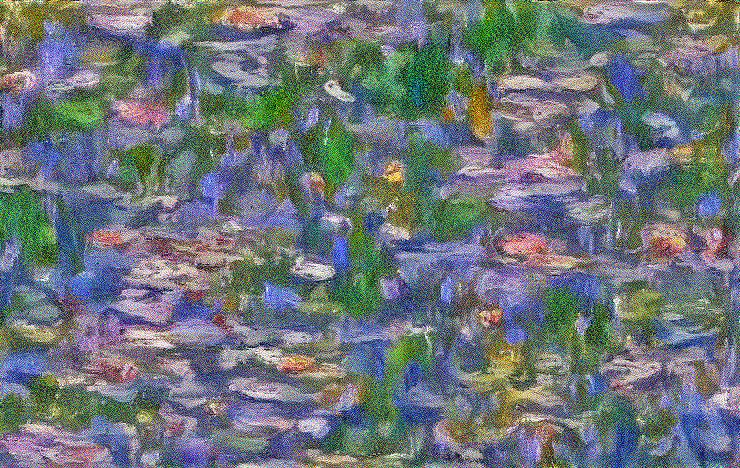

Iteration 50 completed in 29s
Current loss value: 6271321.5



In [10]:
x = np.random.uniform(0, 255, result_image.shape) - 128.
res = run(style_evaluator, x, num_iter=50)

In [10]:
def total_variation_loss(x, exp=1.25):
    _, d1, d2, d3 = x.shape
    if K.image_data_format() == 'channels_first':
        a = K.square(x[:, :, :d2 - 1, :d3 - 1] - x[:, :, 1:, :d3 - 1])
        b = K.square(x[:, :, :d2 - 1, :d3 - 1] - x[:, :, :d2 - 1, 1:])
    else:
        a = K.square(x[:, :d1 - 1, :d2 - 1, :] - x[:, 1:, :d2 - 1, :])
        b = K.square(x[:, :d1 - 1, :d2 - 1, :] - x[:, :d1 - 1, 1:, :])
    return K.sum(K.pow(a + b, exp))

In [11]:
loss_variation = total_variation_loss(result_image) / 5000

loss_with_variation = loss_variation + loss_style

evaluator_with_variation = Evaluator(loss_with_variation, result_image)

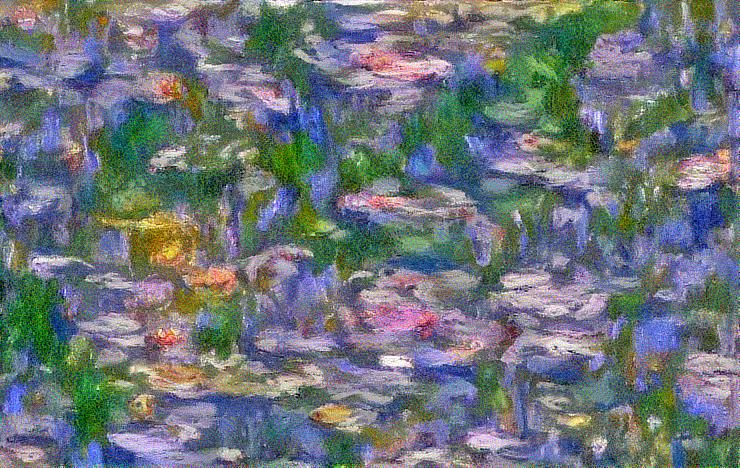

Iteration 100 completed in 30s
Current loss value: 8251257.0



In [13]:
x = np.random.uniform(0, 255, result_image.shape) - 128.
res = run(evaluator_with_variation, x, num_iter=100)

In [12]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [13]:
w, h = load_img(base_image_path).size
base_image = K.variable(preprocess_image(base_image_path))
style_image = K.variable(preprocess_image(style2_image_path, target_size=(h, w)))
combination_image = K.placeholder(style_image.shape)
input_tensor = K.concatenate([base_image,
                              style_image,
                              combination_image], axis=0)

In [14]:
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


In [15]:
feature_outputs = [layer.output for layer in model.layers if '_conv' in layer.name]

loss_content = content_loss(feature_outputs[-1][0, :, :, :],
                            feature_outputs[-1][2, :, :, :])
loss_variation = total_variation_loss(combination_image)
loss_style = K.variable(0.)
for idx, layer_features in enumerate(feature_outputs):
    loss_style += style_loss(layer_features[1, :, :, :], layer_features[2, :, :, :]) * (0.5 ** idx)

loss_content /= 40
loss_variation /= 10000

loss_total = loss_content + loss_variation + loss_style

In [16]:
combined_evaluator = Evaluator(loss_total, combination_image, loss_content=loss_content, 
                               loss_variation=loss_variation, loss_style=loss_style)